# Exploración de hiperparámetros

In [1]:
import pandas as pd
import numpy as np
pd.set_option("max_rows", None)
from os import listdir
from os.path import isfile, join
import re
import os
import sys
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
tab_c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']

from MCMC_steiner_tree import Annealing, pre_pros, plot_graph_by_edges, Trans, weight, Annealing, read_stp, check_steiner_tree

In [2]:
root = {
    "main": "",  # "/Proyecto Sim. Est.",
    "data":"I080/",
    "data_I320":"/I320/",
}

## Importando resultados

In [3]:
f = open('gridsearch/gridsearch.json')
grid_search = json.load(f)
print(grid_search)
f.close()

{'a': [0.5, 0.875, 1.25, 1.625, 2.0], 'b': [0.0, 0.25, 0.5, 0.75, 1.0]}


In [4]:
f = open('gridsearch/params.json')
params = json.load(f)
print(params)
f.close()

{'nf': 3000, 'save_rate': 5, 'repeat': 10}


In [5]:
stp_names = ['i080-001.stp', 'i080-011.stp', 'i080-021.stp', 'i080-031.stp', 'i080-041.stp', 'i080-101.stp',
             'i080-111.stp', 'i080-121.stp', 'i080-131.stp', 'i080-141.stp', 'i080-201.stp', 'i080-211.stp',
             'i080-221.stp', 'i080-231.stp', 'i080-241.stp', 'i080-301.stp', 'i080-311.stp', 'i080-321.stp',
             'i080-331.stp', 'i080-341.stp']

In [6]:
df_opt = pd.read_excel('Testset_I320.xlsx', sheet_name="I080")
df_opt = df_opt.set_index("Name")
df_opt.head()

,|V|,|E|,|T|,DC,time,Opt
Name,,,,,,
i080-001,80.0,120.0,6.0,P,s,1787.0
i080-002,80.0,120.0,6.0,P,s,1607.0
i080-003,80.0,120.0,6.0,P,s,1713.0
i080-004,80.0,120.0,6.0,P,s,1866.0
i080-005,80.0,120.0,6.0,P,s,1790.0


In [7]:
graphs = ['i080-001']
methods = ['BFS_node','DFS_node']
a_values = grid_search['a']
b_values = grid_search['b']
# uniforms

In [8]:
class grafo_resultado(object):
    def __init__(self,name,df=df_opt,folder=root['main']+root['data']):
        name = name if not '.stp' in name else name.replace('.stp','')
        df_edges_G, terminals = read_stp(folder+name+'.stp')
        _, _, dic_edges, _ = pre_pros(df_edges_G)
        self.id = name
        self.terminals = terminals
        self.dic_edges = dic_edges
        self.opt = df['Opt'][name]
        self.size = df['|V|'][name]
        self.length = df['|E|'][name]
        self.difficulty = df['DC'][name]
        self.time = df['time'][name]
        self._results_loaded = False
        self._weights_computed = False
    
    @staticmethod
    def load_cm_path(path):
        with open(path, 'rb') as handle:
            return pickle.load(handle)
    
    def get_results(self,methods,a_values=grid_search['a'],b_values=grid_search['b']):
        results = {}
        for m in methods:
            results[m] = {}
            for i, a in enumerate(a_values):
                results[m][a] = {}
                for j, b in enumerate(b_values):
                    file = 'gridsearch/{}/{}_ixa={}_ixb={}_CM.pickle'.format(self.id,m,i,j)
                    results[m][a][b] = self.load_cm_path(file)
        self.results = results
        self._results_loaded = True
    
    def compute_weight_cm(self):
        weight_cm = {}
        for m in methods:
            weight_cm[m] = {}
            for a in a_values:
                weight_cm[m][a] = {}
                for b in b_values:
                    weight_cm[m][a][b] = [weight(x, self.dic_edges) for x in self.results[m][a][b]]
        self.weight_cm = weight_cm
        self._weights_computed = True
        self.compute_weight_final()
    
    def compute_weight_final(self):
        weight_final = {}
        for m in methods:
            weight_final[m] = {}
            for a in a_values:
                weight_final[m][a] = {}
                for b in b_values:
                    if self._weights_computed:
                        weight_final[m][a][b] = self.weight_cm[m][a][b][-1]
                    else:
                        x = self.results[m][a][b][-1]
                        weight_final[m][a][b] = weight(x, self.dic_edges)
        self.weight_final = weight_final
    """
    @staticmethod
    def lista(m,a,b):
        m = [m] if not type(m)==list else m
        a = [a] if not type(a)==list else a
        b = [b] if not type(b)==list else b
        return m, a, b
    
    def get_cm(self,methods,a,b):
        methods,a_values,b_values = lista(methods,a,b)
        dic = {}
        for m in methods:
            dic[m] = {}
            for a in a_values:
                dic[m][a] = {}
                for b in b_values:
                    dic[m][a][b] = self.results[m][a][b]"""

In [9]:
%%time
grafo = 'i080-001'
grafo_result = grafo_resultado(grafo)
grafo_result.get_results(methods)
# grafo_result.results['BFS_node'][0.875][0.25]

CPU times: user 78.8 ms, sys: 64 µs, total: 78.9 ms
Wall time: 72.3 ms


In [10]:
%%time
grafo_result.compute_weight_cm()

CPU times: user 197 ms, sys: 0 ns, total: 197 ms
Wall time: 196 ms


In [11]:
def plot_a(grafo_result,a_values,b,methods,log=False):
    fig, ax = plt.subplots(1, 1, figsize=(25*2, 18))
    N = len(grafo_result.results[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    for i, a in enumerate(a_values):
        ax.plot(Ns,grafo_result.weight_cm['DFS_node'][a][b], color=tab_c[i], label='DFS_node a={}'.format(a), linestyle='dotted')
        ax.plot(Ns,grafo_result.weight_cm['BFS_node'][a][b], color=tab_c[i], label='BFS_node a={}'.format(a), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="tab:cyan")
    ax.set_title('Pesos para distintos valores de a, grafo = {}, b={}'.format(grafo_result.id,b))
    if log:
        ax.set_yscale('log')

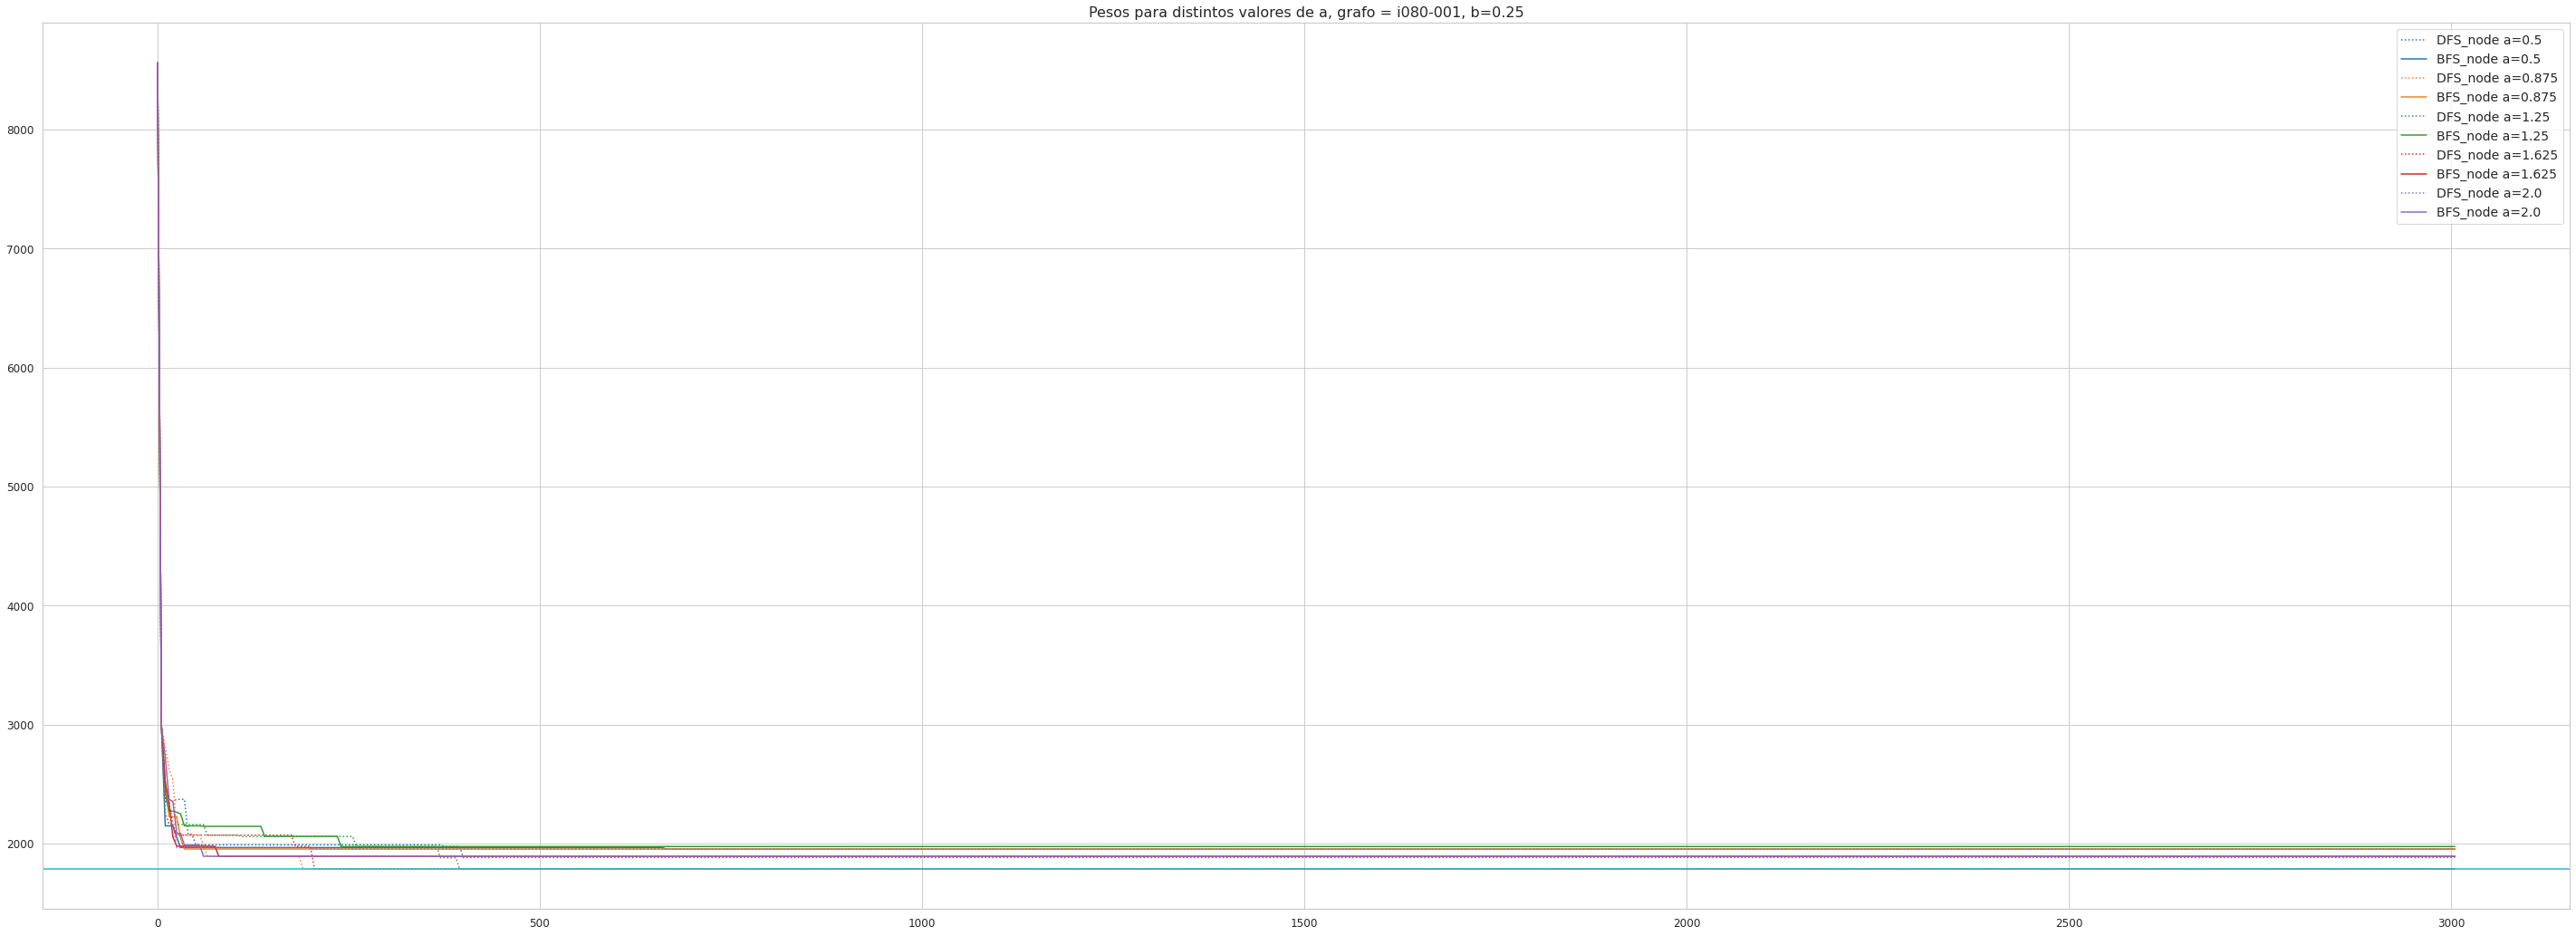

In [12]:
b = 0.25
plot_a(grafo_result,a_values,b,methods);

In [13]:
def plot_b(grafo_result,b_values,a,methods,log=False):
    fig, ax = plt.subplots(1, 1, figsize=(25*2, 18))
    N = len(grafo_result.results[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    for j, b in enumerate(b_values):
        ax.plot(Ns,grafo_result.weight_cm['DFS_node'][a][b], color=tab_c[j], label='DFS_node b={}'.format(b), linestyle='dotted')
        ax.plot(Ns,grafo_result.weight_cm['BFS_node'][a][b], color=tab_c[j], label='BFS_node b={}'.format(b), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="tab:cyan")
    ax.set_title('Pesos para distintos valores de b, grafo = {}, a={}'.format(grafo_result.id,a))
    if log:
        ax.set_yscale('log')

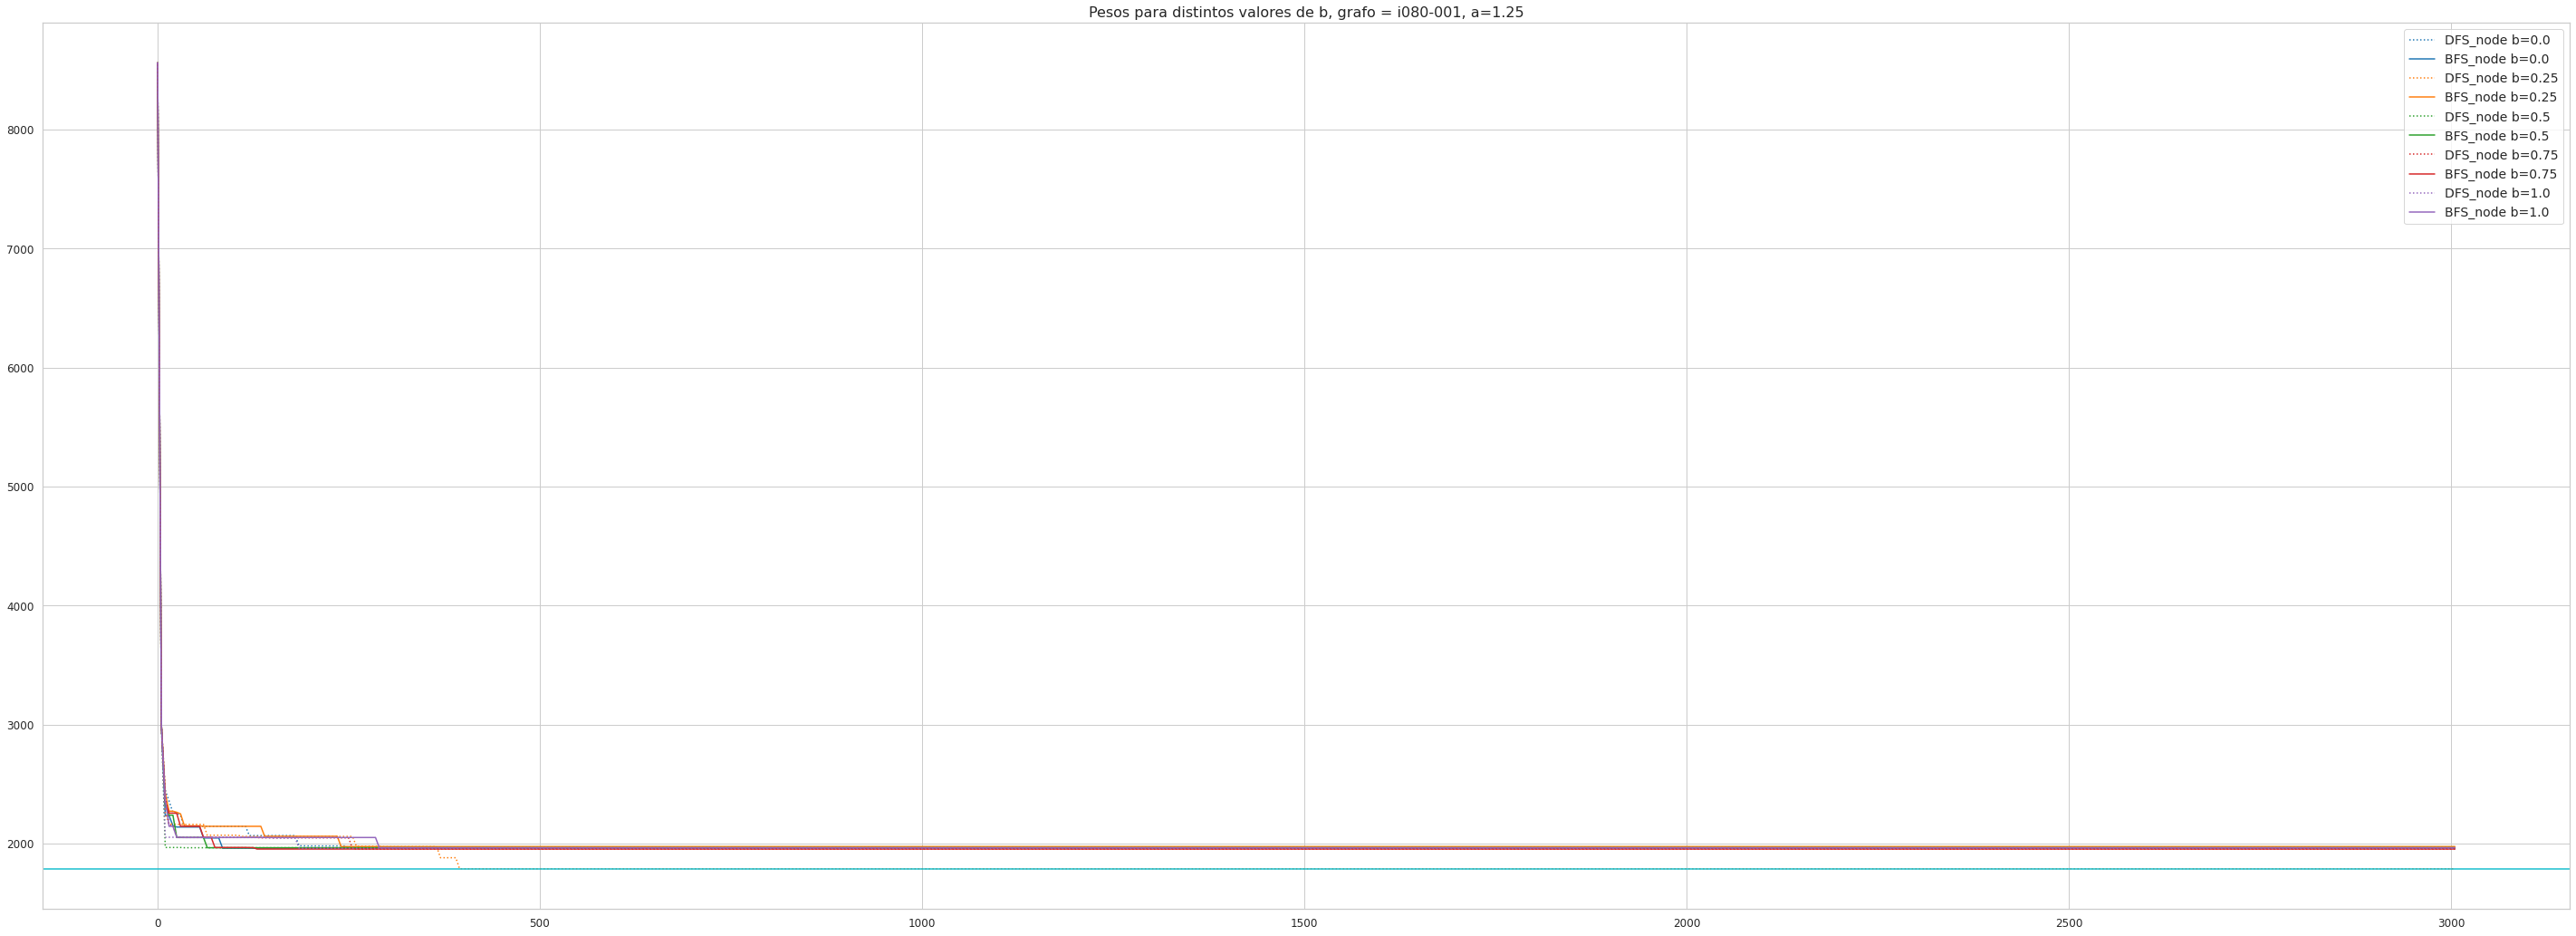

In [14]:
a = 1.25
plot_b(grafo_result,b_values,a,methods);

In [15]:
def plot_ab_grid(grafo_obj,metodo,a_values,b_values):
    if type(metodo)==list:
        
    matrix = np.zeros((len(a_values),len(b_values)))
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            matrix[i][j] = grafo_obj.weight_final[metodo][a][b] - grafo_obj.opt
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(8, 6))
        ax = sns.heatmap(matrix, square=True,xticklabels=a_values, 
                         yticklabels=b_values, linewidths=.5)
        plt.title('Pesos para distintos valores de a y b, grafo: {},, metodo={}'.format(grafo_result.id,metodo))
        plt.show()

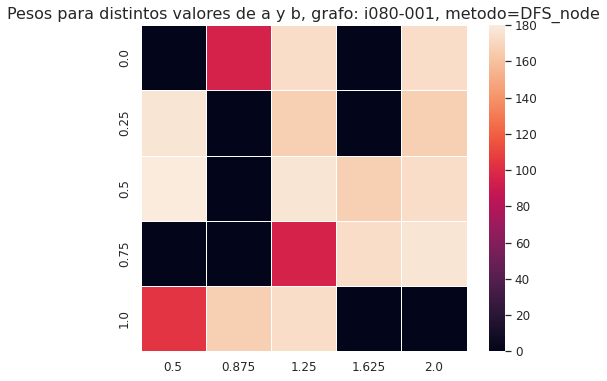

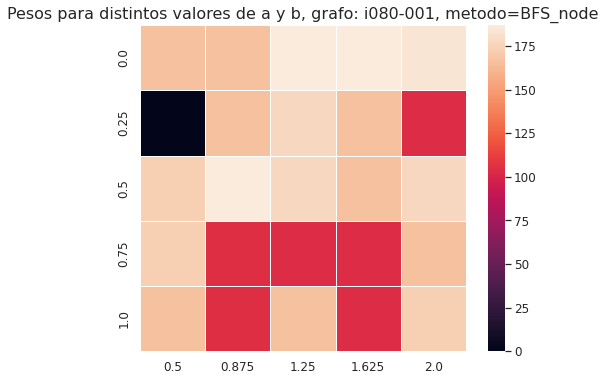

In [16]:
plot_ab_grid(grafo_result,'DFS_node',a_values,b_values)
plot_ab_grid(grafo_result,'BFS_node',a_values,b_values)

---

In [17]:
methods = ['BFS_node','DFS_node']
a_values = grid_search['a']
b_values = grid_search['b']

In [18]:
%%time
for grafo in stp_names:
    result_grafos = {}
    result_grafos[grafo] = grafo_resultado(grafo)
    result_grafos[grafo].get_results(methods)
    result_grafos[grafo].compute_weight_cm()

CPU times: user 12 s, sys: 89.4 ms, total: 12.1 s
Wall time: 11.9 s


---